In [23]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline 
nx.__version__

'3.2.1'

In [24]:
# (node, danger_power)
# 0-safe; 9-danger
default_safe_value=0
#1

# G = nx.grid_graph(dim=[25, 25])  # nodes are two-tuples (x,y)

# danger_points=[((14,13),9),((10,12),9),((0,15),7),((6,6),8),((3,10),7),((24,22),6), ((3,5),7), ((5,23),9),((23,10),7),((8,0),9),((17,2),9),((8,19),5),((8,18),9),((9,23),9),((6,2),9),((5,24),9),((20,20),8)]

# origin_point_x= 23
# origin_point_y= 1
# destination_point_x=1
# destination_point_y= 23

#2

# G = nx.grid_graph(dim=[40, 20])  # nodes are two-tuples (x,y)

# danger_points=[((5,7),9),((3,7),8),((7,7),8),((16,23),8),((18,23),8),((14,23),5),((12,23),9),((10,23),9),((14,20),7),((14,26),7),((2,37),6),((2,39),5),((4,36),9)]

# origin_point_x= 1
# origin_point_y= 1
# destination_point_x=18
# destination_point_y= 38


#3

G = nx.grid_graph(dim=[30, 50])  # nodes are two-tuples (x,y)
pos = nx.kamada_kawai_layout(G)

G=G.to_directed()


danger_points=[((5,10),9),((3,10),8),((7,10),8),((7,10),9),((8,9),8),((5,0),8),((16,23),8),((18,23),8),((14,23),5),
               ((12,23),9),((10,23),9),((14,20),7),((14,26),7), ((20,10),6),((26,9),9),((24,14),9),((24,10),8),((24,18),8),
               ((24,16),9),((43,14),9),((40,15),9),((45,15),8),((37,15),8),((28,15),9),((48,15),8),
              ((45,7),9),((46,7),9),((45,8),9),
              ((45,16),9),((45,17),9),
              ((25,2),9),((24,2),9),((25,3),9),
              ((30,15),9),((29,14),9),((28,15),9),
              ((10,30),9),((11,29),9),((9,30),9),((8,28),9),((20,0),9),((19,0),9)]


origin_point_x= 3
origin_point_y= 7
destination_point_x= 45
destination_point_y= 28


origin_node= (origin_point_x,origin_point_y)
destination_node=(destination_point_x,destination_point_y)


In [25]:
def dist_euclidean(a, b):
    (x1,y1)=a
    (x2,y2)=b
    return ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** 0.5
    # return 0

In [26]:
def gauss_filter(x,y,p1,p2, sigma):
    # return np.exp(-((p1-x)*(p1-x)+((p2-y)*(p2-y)))/(2*sigma*sigma))/(2*np.pi*(sigma*sigma))
    return np.exp(-((p1-x)*(p1-x)+((p2-y)*(p2-y)))/(2*sigma*sigma))

In [27]:
def get_nodes_attributes (G1, danger_points1,name_attr1:str,sigma_local=0.1, sigma_wide=3, k_local=1,k_wide=1,default_value=0,improving_attr=True):
    attr_dict={n:{name_attr1:default_value} for n in G1.nodes}
    L=list(attr_dict.values())
    for n in G1.nodes:
        for i in range(len(danger_points1)):
            (d_point,d_value)=danger_points1[i]
            addition_value=d_value*(gauss_filter(n[0],n[1],d_point[0],d_point[1],sigma_local)*k_local+gauss_filter(n[0],n[1],d_point[0],d_point[1],sigma_wide)*k_wide)
            if improving_attr:
                attr_dict[n][name_attr1]=attr_dict[n][name_attr1]-addition_value
            else:
                attr_dict[n][name_attr1]=attr_dict[n][name_attr1]+addition_value
    if improving_attr:
        min_attr_dict= min([L[i][name_attr1] for i in range(len(L))])
        for n in G1.nodes:
            attr_dict[n][name_attr1]=attr_dict[n][name_attr1]+abs(min_attr_dict)
    return attr_dict

In [28]:
danger_attr=get_nodes_attributes(G,danger_points,"danger_attr",default_value=default_safe_value,improving_attr=False)
nx.set_node_attributes(G,danger_attr)
# [G.nodes[n]["danger_attr"] for n in G.nodes]

In [29]:
def get_edges_attributes(G1,name_attr1,k_length=0.5,k_attr=0.5):
    attr_dict={edge:{name_attr1:0} for edge in G1.edges}
    for edge in G1.edges:
        # IF DIGRAF
        # attr_dict[edge][name_attr1]=G1.nodes[edge[1]]["danger_attr"]*k_attr+k_length*G1.edges[edge]["length"]
        # IF NOT DIRECTED GRAF:
        max_val=max(G1.nodes[edge[1]]["danger_attr"],G1.nodes[edge[0]]["danger_attr"])
        attr_dict[edge][name_attr1]=max_val*k_attr+k_length*G1.edges[edge]["length"]
    return attr_dict
    

In [30]:
nx.set_edge_attributes(G,{edge:{"length":1} for edge in G.edges})
# If the edge value was not a "weight", the algorithm did not work correctly 
danger_attr_edge=get_edges_attributes(G,"weight")
nx.set_edge_attributes(G,danger_attr_edge)

In [20]:
path_orig_dest_nodes=nx.algorithms.shortest_paths.astar_path(G,origin_node,destination_node,heuristic=dist_euclidean,weight="weight")

In [21]:
path_orig_dest_edges=[(path_orig_dest_nodes[i],path_orig_dest_nodes[i+1])for i in range(len(path_orig_dest_nodes)-1)]


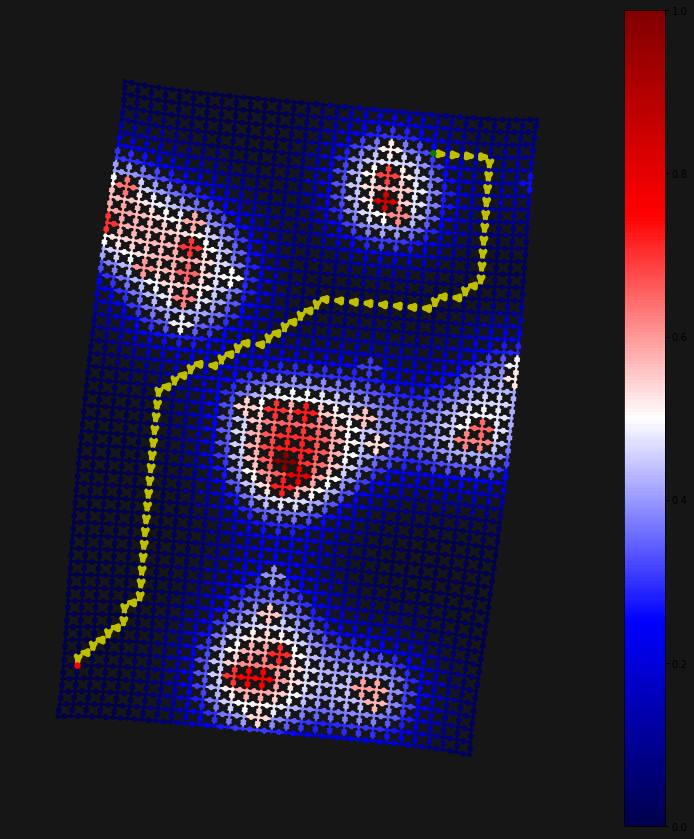

In [22]:
from matplotlib.pyplot import figure

fig, ax = plt.subplots()
fig.set_size_inches(13,15)
# fig.set_dpi(100)

colormap=plt.cm.seismic
nx.draw(G, pos=pos, cmap=colormap,node_color=list(nx.get_node_attributes(G,'danger_attr').values()),node_size=10,
        edge_cmap=colormap, edge_color=list(nx.get_edge_attributes(G,'weight').values()),width=2)

sm = plt.cm.ScalarMappable(cmap=colormap)
sm._A = []
plt.colorbar(sm,ax=ax)
fig.set_facecolor('#161616')
nx.draw_networkx_nodes(G,pos=pos,nodelist=[origin_node,destination_node],node_color=["g","r"],node_size=30)
nx.draw_networkx_edges(G,pos=pos,edgelist=path_orig_dest_edges,edge_color = "y",width=5)
plt.show()

In [ ]:
   # for u, v, d in G.edges(data=True):
   #     print(u,v,d)

In [16]:
nodes_to_visit=[(3,7),(46,2),(40,10),(45,20),(20,25),(4,28),(1,15)]

In [17]:
path_circular_nodes=nx.algorithms.approximation.traveling_salesman_problem(G=G,
                                                            nodes=nodes_to_visit, 
                                                                           method=nx.algorithms.approximation.asadpour_atsp, 
                                                                           cycle=False)

In [18]:
path_circular_edges=[(path_circular_nodes[i],path_circular_nodes[i+1])for i in range(len(path_circular_nodes)-1)]
# path_circular_edges

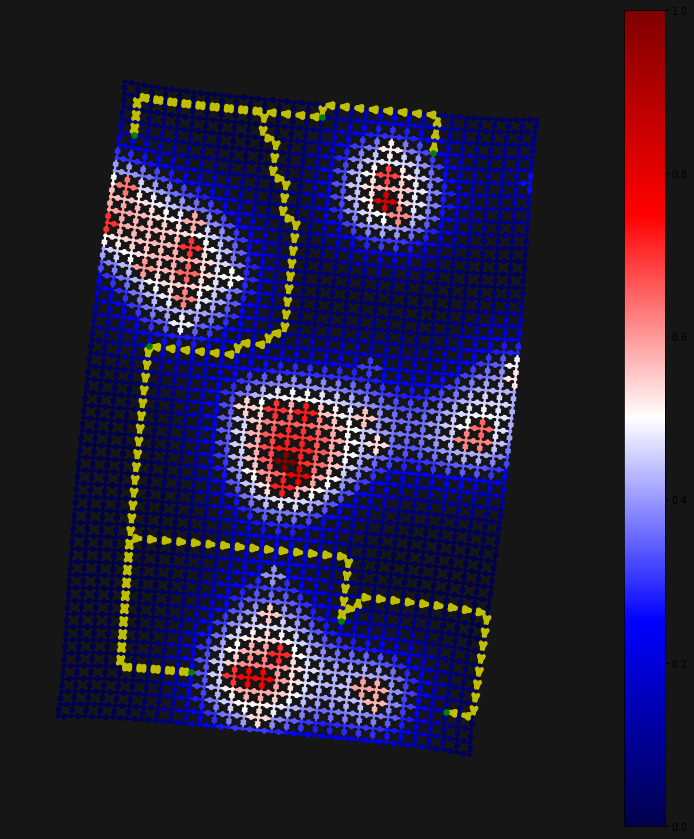

In [19]:
from matplotlib.pyplot import figure

fig, ax = plt.subplots()
fig.set_size_inches(13,15)
# fig.set_dpi(100)

colormap=plt.cm.seismic
nx.draw(G, pos=pos, cmap=colormap,node_color=list(nx.get_node_attributes(G,'danger_attr').values()),node_size=10,
        # edge_cmap=colormap, edge_color=list(nx.get_edge_attributes(G,'danger_attr_edge').values()),width=2)
        edge_cmap=colormap, edge_color=list(nx.get_edge_attributes(G,'weight').values()),width=2)
sm = plt.cm.ScalarMappable(cmap=colormap)
sm._A = []
plt.colorbar(sm,ax=ax)
fig.set_facecolor('#161616')
nx.draw_networkx_nodes(G,pos=pos,nodelist=nodes_to_visit,node_color=["g"],node_size=30)
nx.draw_networkx_edges(G,pos=pos,edgelist=path_circular_edges,edge_color = "y",width=5)
plt.show()